# Packages

In [1]:
# Data wrangling
import pandas as pd
import polars as pl
import polars.selectors as cs
import numpy as np

# Visualisation
import plotnine as pn
import matplotlib.pyplot as plt
from mizani.formatters import comma_format, custom_format, currency_format, percent_format
from IPython.display import clear_output, display
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import plotly.express as px

# Utils
import os
from tqdm.notebook import tqdm
import itertools
import yaml
import warnings
import time
import holidays
import pickle
import datetime

# Modelling
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold

import ray
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.layers import ReLU, LeakyReLU

tf.keras.utils.set_random_seed(1)

rc('text', usetex=False)

jama_colour = [
    "#374e55",
    "#df8f44",
    "#00a1d5",
    "#b24745",
    "#79af97",
    "#6a6599",
    "#80796b",
]

pd.set_option("display.max.columns", 500)
pd.set_option("display.max.columns", 500)


theme_academic = pn.theme(
    text=pn.element_text(family="Latin Modern Roman"),
    plot_title=pn.element_text(weight="bold", size=14, ha="center"),
    legend_text=pn.element_text(size=9),  # Smaller font for legend items
    panel_background=pn.element_rect(fill="white"),  # Clean white background
    panel_border=pn.element_rect(color="grey", size=0.5),
    axis_ticks=pn.element_line(color="grey"),
    panel_grid_major=pn.element_line(color="grey", size=0.1, alpha=0.3),
    panel_grid_minor=pn.element_line(color="grey", size=0.1, alpha=0.3),
    legend_background=pn.element_rect(fill="white", color=None),
    legend_key=pn.element_rect(fill="white", color=None),
    plot_margin=0.02,
    figure_size=(6, 4),  # Set default figure size (width, height in inches)
)

%matplotlib inline

# Loading the data

In [2]:
df = pl.read_csv(
    "../0_data/preprocessed/df_final_reduced.csv", try_parse_dates=True
).filter(pl.col("datetime") >= pd.Timestamp("2021-09-01 00:00"))

df.head()

shape: (5, 4)
┌─────────────────────┬──────────┬────────────────────────────┬─────────────────────────────────┐
│ datetime            ┆ kWh      ┆ Zurich_shortwave_radiation ┆ Zurich_soil_temperature_7_to_2… │
│ ---                 ┆ ---      ┆ ---                        ┆ ---                             │
│ datetime[μs]        ┆ f64      ┆ f64                        ┆ f64                             │
╞═════════════════════╪══════════╪════════════════════════════╪═════════════════════════════════╡
│ 2021-09-01 00:00:00 ┆ 5.1633e6 ┆ 0.0                        ┆ 16.042                          │
│ 2021-09-01 01:00:00 ┆ 5.0777e6 ┆ 0.0                        ┆ 15.892                          │
│ 2021-09-01 02:00:00 ┆ 4.9315e6 ┆ 0.0                        ┆ 16.042                          │
│ 2021-09-01 03:00:00 ┆ 4.7878e6 ┆ 0.0                        ┆ 15.942                          │
│ 2021-09-01 04:00:00 ┆ 4.7038e6 ┆ 0.0                        ┆ 15.792001                       │
└─────────────────────┴──────────┴────────────────────────────┴─────────────────────────────────┘

In [3]:
df.shape

(26304, 4)

# Missing values

Just forward fill for now.

In [4]:
df = df.fill_null(strategy="forward")

# Ensure 1 hour gaps

- and availability of full days (to walk in 24 hour steps)

In [5]:
(df["datetime"] - df["datetime"].shift(1)).value_counts()

shape: (2, 2)
┌──────────────┬───────┐
│ datetime     ┆ count │
│ ---          ┆ ---   │
│ duration[μs] ┆ u32   │
╞══════════════╪═══════╡
│ null         ┆ 1     │
│ 1h           ┆ 26303 │
└──────────────┴───────┘

In [6]:
df["datetime"].min()

datetime.datetime(2021, 9, 1, 0, 0)

In [7]:
df["datetime"].max()

datetime.datetime(2024, 8, 31, 23, 0)

# Calendar Features

In [8]:
df = df.with_columns(
    day_of_month=pl.col("datetime").dt.day(),
    day_of_year=pl.col("datetime").dt.ordinal_day(),
    day_of_week=pl.col("datetime").dt.weekday(),
    month=pl.col("datetime").dt.month(),
    hour=pl.col("datetime").dt.hour(),
    year=pl.col("datetime").dt.year(),
)

# Holidays

In [9]:
# Define the region (Canton of Berne) and the country (Switzerland)
country = "CH"
prov = "ZH"

# Create a list of the regional holidays for the canton of Berne
regional_holidays = holidays.CH(
    years=df["datetime"].dt.year().unique().to_list(), prov=prov
)

In [10]:
holiday_df = pl.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
).sort("holiday_date")

holiday_df.head()

shape: (5, 2)
┌────────────────┬──────────────┐
│ holiday_name   ┆ holiday_date │
│ ---            ┆ ---          │
│ str            ┆ date         │
╞════════════════╪══════════════╡
│ Neujahrestag   ┆ 2021-01-01   │
│ Berchtoldstag  ┆ 2021-01-02   │
│ Karfreitag     ┆ 2021-04-02   │
│ Ostermontag    ┆ 2021-04-05   │
│ Tag der Arbeit ┆ 2021-05-01   │
└────────────────┴──────────────┘

In [11]:
df = (
    df.with_columns(date=pl.col("datetime").dt.date())
    .join(holiday_df, how="left", left_on="date", right_on="holiday_date")
    .drop("date")
    .with_columns(holiday_name=pl.col("holiday_name").fill_null("no_holiday"))
)

df.head()

shape: (5, 11)
┌───────────────┬──────────┬───────────────┬──────────────┬───┬───────┬──────┬──────┬──────────────┐
│ datetime      ┆ kWh      ┆ Zurich_shortw ┆ Zurich_soil_ ┆ … ┆ month ┆ hour ┆ year ┆ holiday_name │
│ ---           ┆ ---      ┆ ave_radiation ┆ temperature_ ┆   ┆ ---   ┆ ---  ┆ ---  ┆ ---          │
│ datetime[μs]  ┆ f64      ┆ ---           ┆ 7_to_2…      ┆   ┆ i8    ┆ i8   ┆ i32  ┆ str          │
│               ┆          ┆ f64           ┆ ---          ┆   ┆       ┆      ┆      ┆              │
│               ┆          ┆               ┆ f64          ┆   ┆       ┆      ┆      ┆              │
╞═══════════════╪══════════╪═══════════════╪══════════════╪═══╪═══════╪══════╪══════╪══════════════╡
│ 2021-09-01    ┆ 5.1633e6 ┆ 0.0           ┆ 16.042       ┆ … ┆ 9     ┆ 0    ┆ 2021 ┆ no_holiday   │
│ 00:00:00      ┆          ┆               ┆              ┆   ┆       ┆      ┆      ┆              │
│ 2021-09-01    ┆ 5.0777e6 ┆ 0.0           ┆ 15.892       ┆ … ┆ 9     ┆ 1    ┆ 2021 ┆ no_holiday   │
│ 01:00:00      ┆          ┆               ┆              ┆   ┆       ┆      ┆      ┆              │
│ 2021-09-01    ┆ 4.9315e6 ┆ 0.0           ┆ 16.042       ┆ … ┆ 9     ┆ 2    ┆ 2021 ┆ no_holiday   │
│ 02:00:00      ┆          ┆               ┆              ┆   ┆       ┆      ┆      ┆              │
│ 2021-09-01    ┆ 4.7878e6 ┆ 0.0           ┆ 15.942       ┆ … ┆ 9     ┆ 3    ┆ 2021 ┆ no_holiday   │
│ 03:00:00      ┆          ┆               ┆              ┆   ┆       ┆      ┆      ┆              │
│ 2021-09-01    ┆ 4.7038e6 ┆ 0.0           ┆ 15.792001    ┆ … ┆ 9     ┆ 4    ┆ 2021 ┆ no_holiday   │
│ 04:00:00      ┆          ┆               ┆              ┆   ┆       ┆      ┆      ┆              │
└───────────────┴──────────┴───────────────┴──────────────┴───┴───────┴──────┴──────┴──────────────┘

# Cyclical Encoding

In [12]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))


def encode_cyclically(column_name, periodicity, table):
    # Create sin and cos encoding
    table = table.with_columns(
        sin_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_sin")
    )

    table = table.with_columns(
        cos_transformer(periodicity)
        .fit_transform(table[column_name])
        .alias(f"{column_name}_cos")
    )
    # Drop the old column
    table = table.drop(column_name)

    return table

In [13]:
# Dictionary with column name and calendar periodicity
calendar_features = {
    "day_of_month": 31,
    "day_of_year": 365,
    "day_of_week": 7,
    "month": 12,
    "hour": 24,
}

for column_name, periodicity in calendar_features.items():
    df = encode_cyclically(column_name, periodicity, df)

# sklearn Pipeline

In [14]:
cat_cols = ["holiday_name"]

num_cols = df.select(
    cs.contains(
        "soil_temperature_7_to_28cm",
        "shortwave_radiation",
    )
).columns + ["year"]

manual_cols = df.select(pl.selectors.contains("_cos", "_sin", "is_")).columns

In [15]:
df.drop(manual_cols + cat_cols + num_cols)

shape: (26_304, 2)
┌─────────────────────┬──────────┐
│ datetime            ┆ kWh      │
│ ---                 ┆ ---      │
│ datetime[μs]        ┆ f64      │
╞═════════════════════╪══════════╡
│ 2021-09-01 00:00:00 ┆ 5.1633e6 │
│ 2021-09-01 01:00:00 ┆ 5.0777e6 │
│ 2021-09-01 02:00:00 ┆ 4.9315e6 │
│ 2021-09-01 03:00:00 ┆ 4.7878e6 │
│ 2021-09-01 04:00:00 ┆ 4.7038e6 │
│ …                   ┆ …        │
│ 2024-08-31 19:00:00 ┆ 5.3614e6 │
│ 2024-08-31 20:00:00 ┆ 5.3775e6 │
│ 2024-08-31 21:00:00 ┆ 5.2130e6 │
│ 2024-08-31 22:00:00 ┆ 5.0767e6 │
│ 2024-08-31 23:00:00 ┆ 4.7850e6 │
└─────────────────────┴──────────┘

In [16]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

In [17]:
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

In [18]:
column_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

In [19]:
preprocessor = Pipeline(
    steps=[
        ("column_transformer", column_transformer),
        (
            "variance_threshold",
            VarianceThreshold(threshold=0.0),
        ),  # Drops constant columns after transformations
    ]
)

# Wide Data Format

## Splits

Start by preprocessing the data in hourly frequency:

In [20]:
df_train = df.filter(
    (pl.col("datetime") >= pl.datetime(2021, 9, 1, 0))
    & (pl.col("datetime") <= pl.datetime(2022, 8, 31, 23))
).to_pandas()

df_val = df.filter(
    (pl.col("datetime") >= pl.datetime(2022, 9, 1, 0))
    & (pl.col("datetime") <= pl.datetime(2023, 8, 31, 23))
).to_pandas()

In [21]:
X_train = df_train.drop(columns=["datetime", "kWh"])
X_val = df_val.drop(columns=["datetime", "kWh"])

y_train = df_train["kWh"]
y_val = df_val["kWh"]

In [22]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_train),
    columns=fitted_preprocessor.get_feature_names_out(),
)

X_val_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_val),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [23]:
df_train_preprocessed = pd.concat(
    [df_train.filter(["datetime", "kWh"]), X_train_preprocessed], axis=1
)

df_val_preprocessed = pd.concat(
    [df_val.filter(["datetime", "kWh"]), X_val_preprocessed], axis=1
)

In [24]:
df_trainval = pd.concat(
    [df_train_preprocessed, df_val_preprocessed], axis=0
).reset_index(drop=True)


df_trainval.shape

(17520, 26)

In [25]:
(df_trainval["datetime"] - df_trainval["datetime"].shift(1)).value_counts()

datetime
0 days 01:00:00    17519
Name: count, dtype: int64

## Exogenous Variables

Define parameters:
- h: prediction horizon, here 24 (how far should be predicted into the future at once)
- l: lookback parameter (how many past observations should be considered), here 168 (one week)
    - Y lags
    - X lags

Start with exogenous variables due to edge case:
- at the start of the dataframe, there are no past observations to consider (need to be dropped)
- simplifying assumption: l can only be a multiple of h, so there doesn't need to be rounding applied to come back to the proper setup of predicting at midnight for the next day

In [26]:
h = 24
l = 7 * h
d = len(df_trainval.drop(columns=["datetime", "kWh"]).columns)
slice_points = np.arange(l, df_trainval.shape[0], h)

In [27]:
# y_target size: future y values
# X_target size: past y values + past X values + future X values
y = np.empty((0, 24))
X = np.empty((0, l + l * d + h * d))

for i, origin in enumerate(tqdm(slice_points)):
    # Create splits based on origin
    past_range = df_trainval.iloc[origin - l : origin]
    future_range = df_trainval.iloc[origin : origin + h]

    # Extract chunks of information
    y_future = future_range["kWh"].to_numpy()
    y_lags = past_range["kWh"].to_numpy()

    X_future = future_range.drop(columns=["datetime", "kWh"]).to_numpy().flatten()
    X_lags = past_range.drop(columns=["datetime", "kWh"]).to_numpy().flatten()

    # Append the information to the existing arrays
    y = np.vstack([y, y_future])
    X = np.vstack([X, np.hstack([X_future, X_lags, y_lags])])

  0%|          | 0/723 [00:00<?, ?it/s]

In [28]:
train_size = df_train_preprocessed.shape[0] - l
val_size = df_val_preprocessed.shape[0]

In [29]:
train_size

8592

In [30]:
val_size

8760

In [31]:
X_train = X[: int(train_size / h)]
y_train = y[: int(train_size / h)]

X_val = X[int(train_size / h) : int(train_size / h) + int(val_size / h)]
y_val = y[int(train_size / h) : int(train_size / h) + int(val_size / h)]

In [32]:
len(y_val.flatten())

8760

## Create function for tuning for aggregation

In [33]:
def aggregate_df(df, train_size, val_size, l=168, h=24):
    assert (
        l % h == 0
    ), f"Warning: 'l' ({l}) is not a multiple of 'h' ({h}). The aggregation may not work as expected."

    # Adjust train size for edge case of no historical data at start of data frame
    train_size = train_size - l
    d = len(df.drop(columns=["datetime", "kWh"]).columns)

    slice_points = np.arange(l, df.shape[0], h)

    # y_target size: future y values
    # X_target size: past y values + past X values + future X values
    y = np.empty((0, 24))
    X = np.empty((0, l + l * d + h * d))

    for i, origin in enumerate(slice_points):
        # Create splits based on origin
        past_range = df.iloc[origin - l : origin]
        future_range = df.iloc[origin : origin + h]

        # Extract chunks of information
        y_future = future_range["kWh"].to_numpy()
        y_lags = past_range["kWh"].to_numpy()

        X_future = future_range.drop(columns=["datetime", "kWh"]).to_numpy().flatten()
        X_lags = past_range.drop(columns=["datetime", "kWh"]).to_numpy().flatten()

        # Append the information to the existing arrays
        y = np.vstack([y, y_future])
        X = np.vstack([X, np.hstack([X_future, X_lags, y_lags])])

    # Recreate splits
    if train_size > 0:
        X_train = X[: int(train_size / h)]
        y_train = y[: int(train_size / h)]
    else:
        X_train = None
        y_train = None

    # Handle validation size being zero
    if val_size > 0:
        X_val = X[int(train_size / h) : int(train_size / h) + int(val_size / h)]
        y_val = y[int(train_size / h) : int(train_size / h) + int(val_size / h)]
    else:
        X_val = None
        y_val = None

    return (X_train, X_val, y_train, y_val)

In [34]:
X_train, X_val, y_train, y_val = aggregate_df(
    df=df_trainval,
    train_size=df_train_preprocessed.shape[0],
    val_size=df_val_preprocessed.shape[0],
    l=168,
    h=24,
)

# Hyperparameter Tuning

## Manual test

In [35]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100,
    decay_rate=0.98,
    staircase=True,
)


# Define the model
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(24),
    ]
)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=rmse,
    metrics=[RootMeanSquaredError()],
)

# Set up Tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=100, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[tensorboard_callback, early_stopping],
    verbose=0,
)

In [ ]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=rmse,
    metrics=[RootMeanSquaredError()],
)

# Set up Tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up callbacks
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=100, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    callbacks=[tensorboard_callback, early_stopping],
    verbose=0,
)

In [256]:
val_preds = pd.DataFrame(
    {
        "datetime": df_val_preprocessed["datetime"],
        "pred": model.predict(X_val).flatten(),
        "kWh": y_val.flatten(),
    }
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [257]:
loss = root_mean_squared_error(y_pred=val_preds["pred"], y_true=val_preds["kWh"])
loss

256095.7007710484

In [261]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    val_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Validation Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [260]:
# Need to account for the edge case of missing historical data at the start:
# Remove the first l observations from the datetime col that haven't been used
train_preds = pd.DataFrame(
    {
        "datetime": df_train_preprocessed["datetime"].iloc[
            df_train.shape[0] - y_train.shape[0] * y_train.shape[1] :
        ],
        "pred": model.predict(X_train).flatten(),
        "kWh": y_train.flatten(),
    }
)


# Create the figure with step lines for both actual and predicted values
fig = px.line(
    train_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Training Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## RayTune Tuning Loop

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [38]:
def keras_trainable(config):
    # try:
    # Define the learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=config["initial_learning_rate"],
        decay_steps=config["decay_steps"],
        decay_rate=config["decay_rate"],
        staircase=True,
    )

    # Build the model dynamically based on num_layers and units_per_layer
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    if config["activation"] == "ReLU":
        for _ in range(config["num_layers"]):
            model.add(Dense(config["units_per_layer"]))
            model.add(ReLU())
    elif config["activation"] == "LeakyReLU":
        for _ in range(config["num_layers"]):
            model.add(Dense(config["units_per_layer"]))
            model.add(LeakyReLU())

    model.add(Dense(config["h"]))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss=rmse,
        metrics=[RootMeanSquaredError()],
    )

    # Early stopping
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=50,
        restore_best_weights=True,
    )

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        callbacks=[early_stopping],
        verbose=0,
    )

    # Report validation loss to Ray Tune
    train.report({"loss": min(history.history["val_loss"])})

    # except Exception as e:
    #     train.report({"loss": float("inf")})

In [ ]:
# Need this line for locally defined modules to work with ray
# ray.init(runtime_env={"working_dir": "."}, ignore_reinit_error=True)
np.random.seed(42)

analysis = tune.run(
    keras_trainable,
    config={
        "initial_learning_rate": tune.loguniform(1e-5, 1e-2),
        "decay_steps": tune.choice([10, 25, 50, 100, 200]),
        "decay_rate": tune.uniform(0.8, 0.99),
        "num_layers": tune.randint(1, 5 + 1),  # Max 5 layers
        "units_per_layer": tune.choice([32, 64, 128, 256, 512]),
        "activation": tune.choice(["ReLU", "LeakyReLU"]),
        "batch_size": tune.choice([16, 32, 64, 128]),
        "epochs": 2000,
        "h": 24,
    },
    metric="loss",
    mode="min",
    name="DNN",
    search_alg=OptunaSearch(),
    time_budget_s=60 * 60 * 9,
    num_samples=-1,
    max_concurrent_trials=4,
    raise_on_failed_trial=False,
    trial_dirname_creator=lambda trial: f"{trial.trainable_name}_{trial.trial_id}",
)

In [41]:
analysis.dataframe().to_csv("7_ANN_trials.csv", index=False)

# Validation Performance of the Best Model

In [36]:
trials_df = pl.read_csv("7_ANN_trials.csv")

In [37]:
trials_df.shape[0]

221

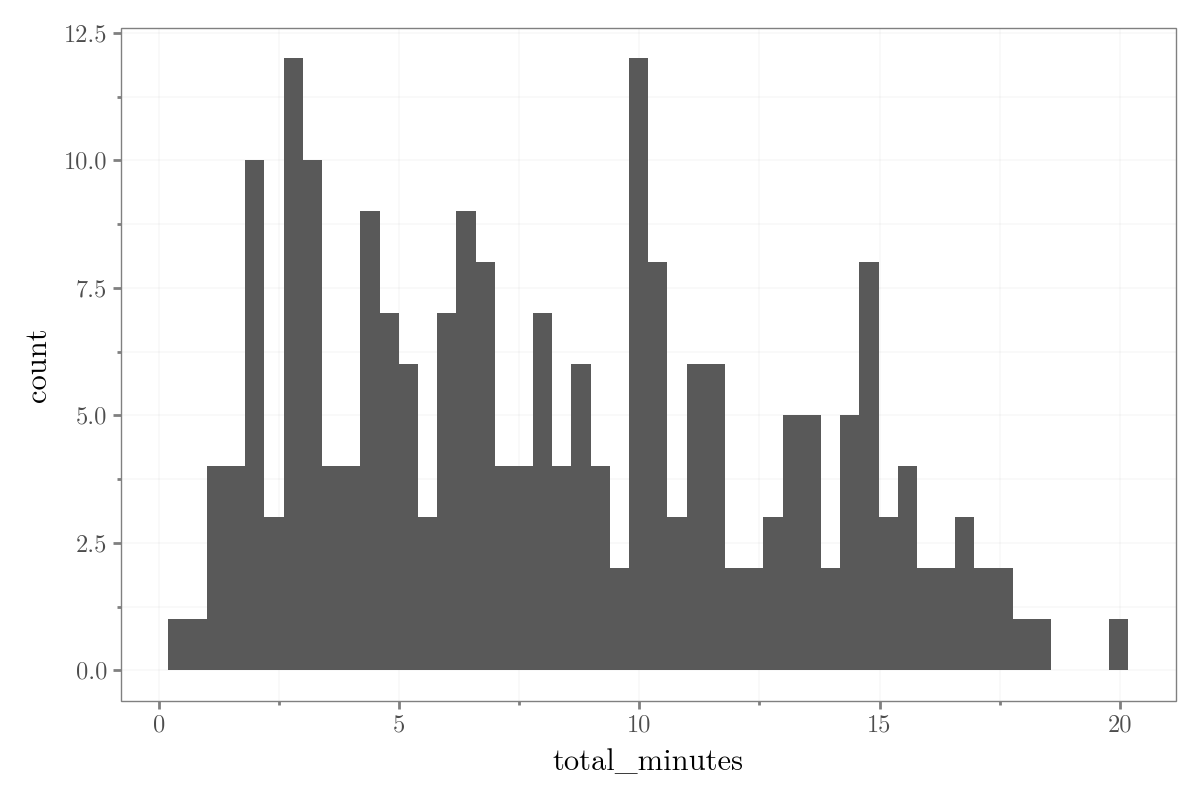

In [38]:
(
    pn.ggplot(
        data=(trials_df.with_columns(total_minutes=pl.col("time_total_s") / 60)),
        mapping=pn.aes("total_minutes"),
    )
    + pn.geom_histogram(bins=50)
    + theme_academic
)

In [39]:
# Read best combination from data frame
best_hyperparams_df = (
    pl.read_csv("7_ANN_trials.csv")
    .sort("loss")
    .head(1)
    .select(pl.selectors.contains("config/"))
    .unpivot()
    .with_columns(pl.col("variable").str.replace("config/", ""))
)

# Make dictionary (all strings)
best_hyperparams = dict(
    zip(best_hyperparams_df["variable"], best_hyperparams_df["value"])
)

# Convert strings to correct data types
converted_params = {
    "initial_learning_rate": float(best_hyperparams["initial_learning_rate"]),
    "decay_steps": int(best_hyperparams["decay_steps"]),
    "decay_rate": float(best_hyperparams["decay_rate"]),
    "num_layers": int(best_hyperparams["num_layers"]),
    "units_per_layer": int(best_hyperparams["units_per_layer"]),
    "activation": best_hyperparams["activation"],
    "batch_size": int(best_hyperparams["batch_size"]),
    "epochs": int(best_hyperparams["epochs"]),
    "h": int(best_hyperparams["h"]),
}

converted_params

{'initial_learning_rate': 0.0011809050859945204,
 'decay_steps': 50,
 'decay_rate': 0.9847779829145855,
 'num_layers': 3,
 'units_per_layer': 512,
 'activation': 'LeakyReLU',
 'batch_size': 16,
 'epochs': 2000,
 'h': 24}

In [ ]:
pl.read_csv("7_ANN_trials.csv").sort("loss").head(1)["loss"]

shape: (1,)
Series: 'loss' [f64]
[
	224282.4375
]

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=converted_params["initial_learning_rate"],
    decay_steps=converted_params["decay_steps"],
    decay_rate=converted_params["decay_rate"],
    staircase=True,
)

# Build the model dynamically based on num_layers and units_per_layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

if converted_params["activation"] == "ReLU":
    for _ in range(converted_params["num_layers"]):
        model.add(Dense(converted_params["units_per_layer"]))
        model.add(ReLU())
elif converted_params["activation"] == "LeakyReLU":
    for _ in range(converted_params["num_layers"]):
        model.add(Dense(converted_params["units_per_layer"]))
        model.add(LeakyReLU())

model.add(Dense(converted_params["h"]))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=rmse,
    metrics=[RootMeanSquaredError()],
)

# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

# Set up Tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=converted_params["epochs"],
    batch_size=converted_params["batch_size"],
    callbacks=[early_stopping, tensorboard_callback],
    verbose=0,
)

In [87]:
val_preds = pd.DataFrame(
    {
        "datetime": df_val_preprocessed["datetime"],
        "pred": model.predict(X_val).flatten(),
        "kWh": y_val.flatten(),
    }
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [96]:
loss = root_mean_squared_error(y_pred=val_preds["pred"], y_true=val_preds["kWh"])
loss

239793.79695175262

In [97]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    val_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Validation Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [98]:
# Need to account for the edge case of missing historical data at the start:
# Remove the first l observations from the datetime col that haven't been used
train_preds = pd.DataFrame(
    {
        "datetime": df_train_preprocessed["datetime"].iloc[
            df_train.shape[0] - y_train.shape[0] * y_train.shape[1] :
        ],
        "pred": model.predict(X_train).flatten(),
        "kWh": y_train.flatten(),
    }
)


# Create the figure with step lines for both actual and predicted values
fig = px.line(
    train_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Training Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


# Model Evaluation without Retraining

Evaluate on the holdout period by retraining with the  best_hyperparams chosen from tuning on validation set.

- Train once: on the entire training + validation period, but WITHOUT early stopping, pick the exact number of epochs to train for and train on the full training data set
    - Restore the best weights on the training set? Or just go with it

## Splits

Start by preprocessing the data in hourly frequency:

In [40]:
df_train = df.filter(
    (pl.col("datetime") >= pl.datetime(2021, 9, 1, 0))
    & (pl.col("datetime") <= pl.datetime(2023, 8, 31, 23))
).to_pandas()

df_test = df.filter(pl.col("datetime") >= pl.datetime(2023, 9, 1, 0)).to_pandas()

In [41]:
X_train = df_train.drop(columns=["datetime", "kWh"])
X_test = df_test.drop(columns=["datetime", "kWh"])

y_train = df_train["kWh"]
y_test = df_test["kWh"]

In [42]:
fitted_preprocessor = preprocessor.fit(X_train)

X_train_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_train),
    columns=fitted_preprocessor.get_feature_names_out(),
)

X_test_preprocessed = pd.DataFrame(
    fitted_preprocessor.transform(X_test),
    columns=fitted_preprocessor.get_feature_names_out(),
)

In [43]:
df_train_preprocessed = pd.concat(
    [df_train.filter(["datetime", "kWh"]), X_train_preprocessed], axis=1
)

df_test_preprocessed = pd.concat(
    [df_test.filter(["datetime", "kWh"]), X_test_preprocessed], axis=1
)

In [44]:
df_traintest = pd.concat(
    [df_train_preprocessed, df_test_preprocessed], axis=0
).reset_index(drop=True)

df_traintest.shape

(26304, 26)

In [45]:
(df_traintest["datetime"] - df_traintest["datetime"].shift(1)).value_counts()

datetime
0 days 01:00:00    26303
Name: count, dtype: int64

## Aggregate

In [46]:
X_train, X_test, y_train, y_test = aggregate_df(
    df=df_traintest,
    train_size=df_train_preprocessed.shape[0],
    val_size=df_test_preprocessed.shape[0],
    l=168,
    h=24,
)

## Fit

Here, I can't use early stopping as it would be considered data leakage. Need to blindly train on the training set (train + val) for the number of epochs that seems appropriate from the validation fit.

In [ ]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=converted_params["initial_learning_rate"],
    decay_steps=converted_params["decay_steps"],
    decay_rate=converted_params["decay_rate"],
    staircase=True,
)

# Build the model dynamically based on num_layers and units_per_layer
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

if converted_params["activation"] == "ReLU":
    for _ in range(converted_params["num_layers"]):
        model.add(Dense(converted_params["units_per_layer"]))
        model.add(ReLU())
elif converted_params["activation"] == "LeakyReLU":
    for _ in range(converted_params["num_layers"]):
        model.add(Dense(converted_params["units_per_layer"]))
        model.add(LeakyReLU())

model.add(Dense(converted_params["h"]))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=rmse,
    metrics=[RootMeanSquaredError()],
)

# Set up Tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    X_train,
    y_train,
    # validation_data=(None, None),
    epochs=300,
    batch_size=converted_params["batch_size"],
    callbacks=[tensorboard_callback],
    verbose=0,
)

In [189]:
holdout_preds = pd.DataFrame(
    {
        "datetime": df_test_preprocessed["datetime"],
        "pred": model.predict(X_test).flatten(),
        "kWh": y_test.flatten(),
    }
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [190]:
loss = root_mean_squared_error(
    y_pred=holdout_preds["pred"], y_true=holdout_preds["kWh"]
)
loss

308585.8616855035

In [193]:
# Create the figure with step lines for both actual and predicted values
fig = px.line(
    holdout_preds,
    x="datetime",
    y=["kWh", "pred"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Holdout Fit without Retraining",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

# Customize the layout
fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

# Show the figure
fig.show()

In [192]:
holdout_preds.to_csv("7_ANN_holdout_predictions_no_retraining.csv", index=False)

# Model Evaluation with Retraining

Evaluate on the holdout period by retraining with the best_hyperparams chosen from tuning on validation set.

- Retrain weekly: on the entire training + validation period, but WITHOUT early stopping, pick the exact number of epochs to train for and train on the full training data set
    - Restore the best weights on the training set? Or just go with it
- Add the new week of observations in each step as training data (sliding window) and remove the oldest week

In [47]:
X_traintest = np.vstack([X_train, X_test])
y_traintest = np.vstack([y_train, y_test])

In [169]:
# Daily frequency data: Retrain each week
max_history = 365 * 2
retrain_freq = 7

retrain_points = np.arange(
    X_train.shape[0],
    X_traintest.shape[0],
    retrain_freq,
)

retrain_points

array([ 723,  730,  737,  744,  751,  758,  765,  772,  779,  786,  793,
        800,  807,  814,  821,  828,  835,  842,  849,  856,  863,  870,
        877,  884,  891,  898,  905,  912,  919,  926,  933,  940,  947,
        954,  961,  968,  975,  982,  989,  996, 1003, 1010, 1017, 1024,
       1031, 1038, 1045, 1052, 1059, 1066, 1073, 1080, 1087])

In [170]:
# The year is not a perfect 52 weeks, 2 days are extra, need to
# be careful with the slicers build in a safety
X_traintest.shape[0] - retrain_points[-1]

2

In [171]:
np.amax([0, (test_end_idx - retrain_freq - max_history)])

357

In [ ]:
holdout_pred_dfs = []

# Split point denotes where df is broken into history (2 years max)
# and test period (1 week, then move one week ahead and retrain)
for split_point in tqdm(retrain_points):

    # Get the training and test period for the current "viewpoint week"
    X_train_sliced = X_traintest[np.amax([0, split_point - max_history]) : split_point]
    X_test_sliced = X_traintest[
        split_point : np.amin([split_point + retrain_freq, X_traintest.shape[0]])
    ]

    y_train_sliced = y_traintest[np.amax([0, split_point - max_history]) : split_point]
    y_test_sliced = y_traintest[
        split_point : np.amin([split_point + retrain_freq, X_traintest.shape[0]])
    ]

    # Train the model
    lr_schedule = ExponentialDecay(
        initial_learning_rate=converted_params["initial_learning_rate"],
        decay_steps=converted_params["decay_steps"],
        decay_rate=converted_params["decay_rate"],
        staircase=True,
    )

    # Build the model dynamically based on num_layers and units_per_layer
    model = Sequential()
    model.add(Input(shape=(X_traintest_sliced.shape[1],)))

    if converted_params["activation"] == "ReLU":
        for _ in range(converted_params["num_layers"]):
            model.add(Dense(converted_params["units_per_layer"]))
            model.add(ReLU())
    elif converted_params["activation"] == "LeakyReLU":
        for _ in range(converted_params["num_layers"]):
            model.add(Dense(converted_params["units_per_layer"]))
            model.add(LeakyReLU())

    model.add(Dense(converted_params["h"]))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss=rmse,
        metrics=[RootMeanSquaredError()],
    )

    # Train the model
    history = model.fit(
        X_train_sliced,
        y_train_sliced,
        # validation_data=(None, None),
        epochs=300,
        batch_size=converted_params["batch_size"],
        verbose=0,
    )

    # Append results
    y_preds_holdout = pd.DataFrame(
        {
            "pred": model.predict(X_test_sliced).flatten(),
            "kWh": y_test_sliced.flatten(),
        }
    )
    holdout_pred_dfs.append(y_preds_holdout)

  0%|          | 0/53 [00:00<?, ?it/s]

In [176]:
y_preds_holdout = (
    pd.concat(holdout_pred_dfs, axis=0)
    .reset_index(drop=True)
    .assign(datetime=lambda x: df_test["datetime"])
)

y_preds_holdout.head()

kWh            datetime
0  4.952079e+06 2023-09-01 00:00:00
1  4.789383e+06 2023-09-01 01:00:00
2  4.689283e+06 2023-09-01 02:00:00
3  4.490485e+06 2023-09-01 03:00:00
4  4.345052e+06 2023-09-01 04:00:00

In [177]:
y_preds_holdout.to_csv("7_ANN_holdout_predictions_with_retraining.csv", index=False)

In [179]:
loss = root_mean_squared_error(
    y_pred=y_preds_holdout["pred"], y_true=y_preds_holdout["kWh"]
)
loss

KeyError: 'pred'

In [ ]:
fig = px.line(
    y_preds_holdout,
    x="datetime",
    y=["pred", "kWh"],
    labels={
        "datetime": "Date",
        "value": "Energy Consumption (kWh)",
        "variable": "Series",
    },
    title="Holdout Fit",
    line_shape="hv",  # Set line shape to horizontal-vertical for step chart
)

fig.update_layout(
    template="plotly_white",
    legend=dict(title=""),
    xaxis_title="Date",
    yaxis_title="Energy Consumption (kWh)",
)

fig.show()